In [1]:
import pandas as pd
import numpy as np

# Paths to your files
file_paths = ['Resources/train.txt', 'Resources/test.txt', 'Resources/val.txt']
data_frames = []

In [2]:
for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8') as file:
        data = [line.strip().split(';') for line in file if line.strip()]  # Adjust split based on your delimiter
        df = pd.DataFrame(data, columns=['Sentence', 'Emotion'])
        data_frames.append(df)

In [3]:
# Concatenate all data into a single DataFrame
df = pd.concat(data_frames, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(df.head())

                                            Sentence  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


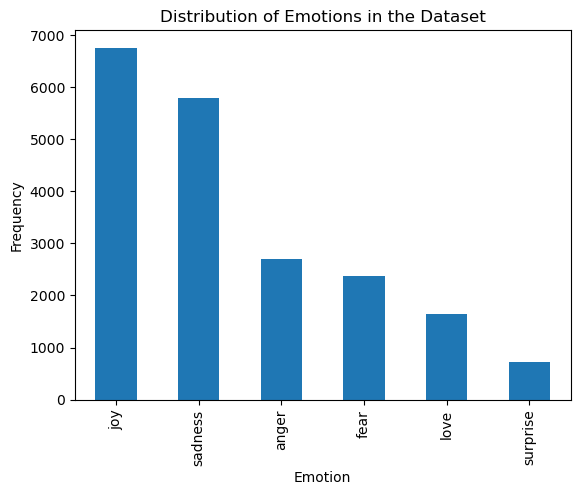

In [4]:
import matplotlib.pyplot as plt

# Plotting the distribution of emotions
emotion_counts = df['Emotion'].value_counts()
emotion_counts.plot(kind='bar')
plt.title('Distribution of Emotions in the Dataset')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical
label_encoder = LabelEncoder()
df['Emotion'] = label_encoder.fit_transform(df['Emotion'])
labels = to_categorical(df['Emotion'])


In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts, max_length=100):
    """Encodes text into input formats with padding and truncation."""
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'  # Ensure tensors are returned suitable for tf.keras
    )

# Encode the sentences
encodings = encode_texts(df['Sentence'])


In [7]:
from sklearn.model_selection import train_test_split

# Assuming 'encodings' is the result from the BERT tokenizer
input_ids = encodings['input_ids'].numpy()  # Convert to numpy array
attention_masks = encodings['attention_mask'].numpy()  # Convert to numpy array

# Split the data
X_train, X_val, y_train, y_val = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.2, random_state=42)


In [8]:
import tensorflow as tf
from transformers import TFBertModel

@tf.keras.utils.register_keras_serializable()
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name='bert-base-uncased', **kwargs):
        super(BertEmbeddingLayer, self).__init__(**kwargs)
        self.model_name = model_name
        self.bert = TFBertModel.from_pretrained(model_name, output_attentions=False, output_hidden_states=False)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state

    def get_config(self):
        config = super(BertEmbeddingLayer, self).get_config()
        config.update({"model_name": self.model_name})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [9]:
from transformers import TFBertModel, BertTokenizer

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Define inputs
input_ids = tf.keras.layers.Input(shape=(100,), dtype=tf.int32, name='input_ids')
attention_masks = tf.keras.layers.Input(shape=(100,), dtype=tf.int32, name='attention_masks')

# Use the custom BertEmbeddingLayer
bert_outputs = BertEmbeddingLayer()([input_ids, attention_masks])

# Use the output from BERT
x = tf.keras.layers.GlobalAveragePooling1D()(bert_outputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)        │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_masks (InputLayer)  │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_embedding_layer          │ (None, 100, 768)          │               0 │ input_ids[0][0],           │
│ (BertEmbeddingLayer)          │                           │                 │ attention_masks[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d      │ (None, 768)               │               0 │ bert_embedding_layer[0][0] │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │          49,216 │ global_average_pooling1d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 64)                │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 6)                 │             390 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 49,606 (193.77 KB)

 Trainable params: 49,606 (193.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model with the numpy arrays
history = model.fit(
    [X_train, train_masks], y_train,
    validation_data=([X_val, val_masks], y_val), 
    epochs=5,
    batch_size=32
)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1287s 3s/step - accuracy: 0.4767 - loss: 1.3750 - val_accuracy: 0.5663 - val_loss: 1.1480
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 4421s 9s/step - accuracy: 0.5860 - loss: 1.1257 - val_accuracy: 0.5957 - val_loss: 1.0878
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1345s 3s/step - accuracy: 0.5980 - loss: 1.0697 - val_accuracy: 0.6137 - val_loss: 1.0557
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1327s 3s/step - accuracy: 0.6132 - loss: 1.0257 - val_accuracy: 0.5828 - val_loss: 1.0786
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6245 - loss: 0.9982

In [23]:
def encode_text(text, max_length=100):
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=max_length,    # Pad & truncate all sentences.
        pad_to_max_length=True,
        return_attention_mask=True, # Construct attention masks.
        return_tensors='tf'      # Return tensorflow tensors.
    )
    return {'input_ids': encoded_dict['input_ids'], 'attention_mask': encoded_dict['attention_mask']}

# Example sentence
test_sentence = "The beautiful melody of this song made me dance"
encoded_test_sentence = encode_text(test_sentence)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\antoi\anaconda3\envs\ai_dev\lib\site-packages\transformers\tokenization_utils_base.py:2888: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [24]:
def predict_emotion(encoded_text):
    probabilities = model.predict(encoded_text)
    # Assuming the model's output layer is softmax and you have a label encoder
    emotion = label_encoder.inverse_transform([probabilities.argmax()])[0]  # Get the most likely emotion
    return emotion

predicted_emotion = predict_emotion([encoded_test_sentence['input_ids'], encoded_test_sentence['attention_mask']])
print(f"The predicted emotion is: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The predicted emotion is: joy


In [25]:
model.save('model/emotion_detection.keras')


In [26]:
model = tf.keras.models.load_model('model/emotion_detection.keras', custom_objects={'BertEmbeddingLayer': BertEmbeddingLayer})

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w